In [1]:
import pandas as pd
import darwinian_shift
from darwinian_shift import DarwinianShift

from darwinian_shift import MonteCarloTest
from darwinian_shift import CDFMonteCarloTest
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

/Users/davidshorthouse/anaconda3/envs/dsenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/davidshorthouse/anaconda3/envs/dsenv/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
def plot_boxplot2(self, spectra=None, plot_scale=None, show_plot=False, colours=None,
                     figsize=(5, 5), return_fig=False, ax=None):
        """
        Boxplot of the expected and observed distributions of mutation scores.
        :param spectra: The mutational spectrum or list of mutational spectra to use.
        :param plot_scale:  Scale for the y-axis (mutation scores). Passed to matplotlib. 'log', 'symlog' etc.
        :param show_plot: If True, will call plt.show().
        :param colours: List of colours. First colour is for the observed data, the subsequent colours are
        for plotting the null distributions from each of the mutational spectra given.
        :param figsize: Size of the figure.
        :param return_fig: If True, will return the figure. Used for testing.
        :param ax: Matplotlib axis to plot on. If None, will create a new figure.
        :return: By default, None. If return_fig=True, will return the figure.
        """
#        if ax is None:
#            fig, ax = plt.subplots(figsize=figsize)
#        else:
#            fig = ax.figure

        spectra = self._get_spectra(spectra)

        colours = self._get_plot_colours(colours, len(spectra)+1)
        data = [get_distribution_from_mutational_spectrum(self.null_scores,
                                                          self.null_mutations[spectrum.rate_column])
                for spectrum in spectra]
        data.append(self.observed_values)
        
        return(data)
    
def get_distribution_from_mutational_spectrum(values, mut_rates, num=1000000):
    mut_rates = np.array(mut_rates)
    weights = mut_rates / mut_rates.sum()
    dist = np.repeat(values, np.random.multinomial(num, weights))
    return dist

d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

def shorten(x):
    if len(x) % 3 != 0: 
        raise ValueError('Input length should be a multiple of three')

    y = ''
    for i in range(len(x) // 3):
        y += d[x[3 * i : 3 * i + 3]]
    return y

def one_to_three(one_letter_code):
    mapping = {'A':'Ala',
               'R':'Arg',
               'N':'Asn',
               'D':'Asp',
               'C':'Cys',
               'Q':'Gln',
               'E':'Glu',
               'G':'Gly',
               'H':'His',
               'I':'Ile',
               'L':'Leu',
               'K':'Lys',
               'M':'Met',
               'F':'Phe',
               'P':'Pro',
               'S':'Ser',
               'T':'Thr',
               'W':'Trp',
               'Y':'Tyr',
               'V':'Val',}
    return mapping[one_letter_code.upper()].upper()


In [3]:
d_CROSS = DarwinianShift(
    data = pd.read_csv("../CROSS_mutations.csv"),
    source_genome = "GRCh37",
    included_mutation_types = "missense")

d_FLOT = DarwinianShift(
    data = pd.read_csv("../FLOT_mutations.csv"),
    source_genome = "GRCh37",
    included_mutation_types = "missense")

d_NT = DarwinianShift(
    data = pd.read_csv("../NT_mutations.csv"),
    source_genome = "GRCh37",
    included_mutation_types = "missense")

## Distance to Ligand

In [4]:
from darwinian_shift import StructureDistanceLookup

pdbdist = StructureDistanceLookup(target_key = "target_selection", distance_to_alpha_carbons=True,
                                  sifts_directory=".", pdb_directory=".")

In [5]:
SPOP_chainC_dist = {
    "gene": "SPOP",
    "pdb_id": "3hqi",
    "pdb_chain": "A",
    "target_selection":"chainID C"}

In [6]:
chainC_CROSS = d_CROSS.run_section(SPOP_chainC_dist, lookup=pdbdist, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

chainC_FLOT = d_FLOT.run_section(SPOP_chainC_dist, lookup=pdbdist, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

chainC_NT = d_NT.run_section(SPOP_chainC_dist, lookup=pdbdist, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

In [7]:
chainC_CROSS.get_pvalues()

{'MC_Mean_glob_k3_pvalue': 0.0031996800319968005,
 'MC_Median_glob_k3_pvalue': 0.00019998000199980003,
 'CDF_MC_glob_k3_pvalue': 0.0015998400159984002}

In [8]:
chainC_FLOT.get_pvalues()

{'MC_Mean_glob_k3_pvalue': 0.10838916108389161,
 'MC_Median_glob_k3_pvalue': 0.37236276372362764,
 'CDF_MC_glob_k3_pvalue': 0.10078992100789921}

In [9]:
chainC_NT.get_pvalues()

{'MC_Mean_glob_k3_pvalue': 0.010998900109989001,
 'MC_Median_glob_k3_pvalue': 0.0463953604639536,
 'CDF_MC_glob_k3_pvalue': 0.0105989401059894}

### Plotting

In [10]:
data_cross = plot_boxplot2(chainC_CROSS)
data_flot = plot_boxplot2(chainC_FLOT)
data_nt= plot_boxplot2(chainC_NT)

basedistcross = data_cross[0]
crossdist = data_cross[1]
basedistflot = data_flot[0]
flotdist = data_flot[1]
basedistnt = data_flot[0]
ntdist = data_nt[1]

basedistcross = pd.DataFrame(basedistcross)
basedistcross["label"] = "base_cross"
basedistcross.columns = ["score", "label"]

basedistflot = pd.DataFrame(basedistflot)
basedistflot["label"] = "base_flot"
basedistflot.columns = ["score", "label"]

basedistnt = pd.DataFrame(basedistnt)
basedistnt["label"] = "base_nt"
basedistnt.columns = ["score", "label"]

crossdist = pd.DataFrame(crossdist)
crossdist["label"] = "cross"

flotdist = pd.DataFrame(flotdist)
flotdist["label"] = "flot"

ntdist = pd.DataFrame(ntdist)
ntdist["label"] = "nt"

testdist_cross = pd.DataFrame([-10])
testdist_cross["label"] = "base_cross"
testdist_cross.columns = ["score", "label"]

testdist_flot = pd.DataFrame([-10])
testdist_flot["label"] = "base_flot"
testdist_flot.columns = ["score", "label"]

testdist_nt = pd.DataFrame([-10])
testdist_nt["label"] = "base_nt"
testdist_nt.columns = ["score", "label"]

combined = pd.concat([basedistcross, crossdist, basedistflot, flotdist,basedistnt, ntdist], axis =0)
combined2 = pd.concat([testdist_cross, crossdist,testdist_flot, flotdist,testdist_nt, ntdist], axis =0)

In [11]:
plt.rcParams['figure.figsize'] = [8, 4]

/var/folders/d9/4lyh6rdd5mdbxby_y5lwsy180000gn/T/ipykernel_280/1768322157.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_yticklabels([0,10,20,30,40,50, 60, 70, 80], size = 14)


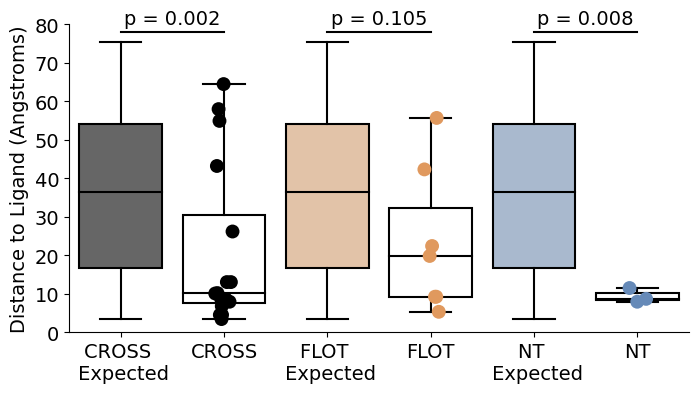

In [12]:
fig, ax = plt.subplots()

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

g1 = sns.boxplot(data = combined, x = "label", y = "score"
                , palette = ["k", "w", "#E0995E", "w", "#668AB8", "w"], showfliers = False)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))
g2 = sns.stripplot(data = combined2, x = "label", y = "score", alpha = 1
                   , palette=["w", "k", "w", "#E0995E", "w", "#668AB8"], size = 10)

x1, x2 = 0, 1  
y, h, col = 78, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+1, "p = 0.002", ha='center', va='bottom', color=col, size = 14)

x1, x2 = 2, 3  
y, h, col = 78, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+1, "p = 0.105", ha='center', va='bottom', color=col, size = 14)

x1, x2 = 4, 5  
y, h, col = 78, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+1, "p = 0.008", ha='center', va='bottom', color=col, size = 14)

g1.set_xlabel("")
g1.set_xticklabels(["CROSS \n Expected", "CROSS", "FLOT \n Expected", "FLOT", "NT \n Expected", "NT"], size = 14)
ax.set_ylim(0, 80)
g1.set_ylabel("Distance to Ligand (Angstroms)", size = 14)
g1.set_yticklabels([0,10,20,30,40,50, 60, 70, 80], size = 14)
#ax.set_yscale("symlog")

sns.despine()

plt.savefig("SPOP_liganddistance.pdf", bbox_inches = "tight")

## Binding DDG

In [13]:
SPOP_prostate = ["F133V", "Y87C", "F102C", "F133I", "F133C", "F133S", "W131G", "F133L", "Y87N", "F133L", "W131L",
"W131S","F102V", "K129E", "F125I", "Y87S", "F125L","F102S", "W131R", "Y87F", "D130E", "F104S", "R368H"]

In [14]:
SPOP = {
    "gene": "SPOP",
    "pdb_id": "3HQI",
    "pdb_chain": "A",
}

In [15]:
from darwinian_shift import FoldXLookup

fold = FoldXLookup(foldx_results_directory = "../Foldx_binding/",
                  sifts_directory = ".",
                  download_sifts=True)

## CROSS

In [16]:
s_cross = d_CROSS.run_section(SPOP, lookup=fold, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

In [17]:
s_cross.get_pvalues()

{'MC_Mean_glob_k3_pvalue': 0.004999500049995001,
 'MC_Median_glob_k3_pvalue': 0.1197880211978802,
 'CDF_MC_glob_k3_pvalue': 0.5377462253774623}

## FLOT

In [18]:
s_flot = d_FLOT.run_section(SPOP, lookup=fold, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

In [19]:
s_flot.get_pvalues()

{'MC_Mean_glob_k3_pvalue': 0.48355164483551644,
 'MC_Median_glob_k3_pvalue': 0.19318068193180682,
 'CDF_MC_glob_k3_pvalue': 0.06619338066193381}

## NT

In [20]:
s_nt = d_NT.run_section(SPOP, lookup=fold, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

In [21]:
s_nt.get_pvalues()

{'MC_Mean_glob_k3_pvalue': 0.21237876212378762,
 'MC_Median_glob_k3_pvalue': 0.8273172682731726,
 'CDF_MC_glob_k3_pvalue': 0.29317068293170684}

In [22]:
d_FLOT.data

,sample,chr,pos,ref,mut,mut_site,tum_globalvaf,gene,transcript,rna_desc,...,xfw_sum,xbw_sum,nfw_sum,nbw_sum,mutant_reads_sum,depth_sum,proportion_samples,subject,transcodon,Group
0,PD47498_m00001,1,11177096,C,T,1 11177096 C T,0.000327,MTOR,CCDS127.1,r.7058g>a,...,8,7,743,687,15,1430,0.016260,PD47498,-,FLOT
1,PD47498_m00003,1,120512170,C,T,1 120512170 C T,0.002034,NOTCH2,CCDS908.1,r.1292g>a,...,61,28,574,232,89,806,0.016260,PD47498,-,FLOT
2,PD47498_m00005,10,89692889,A,G,10 89692889 A G,0.001799,PTEN,CCDS31238.1,r.1730a>g,...,82,76,643,740,158,1383,0.016260,PD47498,-,FLOT
3,PD47498_m00008,12,46244697,C,T,12 46244697 C T,0.000323,ARID2,CCDS31783.1,r.2963c>u,...,19,19,1572,1618,38,3190,0.016260,PD47498,-,FLOT
4,PD47498_m00011,13,28880867,G,A,13 28880867 G A,0.000737,FLT1,CCDS9330.1,r.4015c>u,...,21,15,669,844,36,1513,0.024390,PD47498,-,FLOT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4185,PD50080z,3,53766904,C,T,3 53766904 C T,0.000473,CACNA1D,CCDS2872.1,r.2714c>u,...,2,5,249,175,7,424,0.008333,PD50080,-,FLOT
4186,PD50080z,6,74227923,G,A,6 74227923 G A,0.000358,EEF1A1,CCDS4980.1,r.2086c>u,...,2,3,260,257,5,517,0.008333,PD50080,-,FLOT
4187,PD50080z,9,139412375,C,T,9 139412375 C T,0.001188,NOTCH1,CCDS43905.1,r.1346g>a,...,3,4,46,100,7,146,0.008333,PD50080,-,FLOT
4188,PD50080z,19,15281554,C,T,19 15281554 C T,0.001234,NOTCH3,CCDS12326.1,r.4895g>a,...,9,8,92,72,17,164,0.008333,PD50080,-,FLOT


In [23]:
data_cross = plot_boxplot2(s_cross)
data_flot = plot_boxplot2(s_flot)
data_nt= plot_boxplot2(s_nt)

basedistcross = data_cross[0]
crossdist = data_cross[1]
basedistflot = data_flot[0]
flotdist = data_flot[1]
basedistnt = data_flot[0]
ntdist = data_nt[1]

basedistcross = pd.DataFrame(basedistcross)
basedistcross["label"] = "base_cross"
basedistcross.columns = ["score", "label"]

basedistflot = pd.DataFrame(basedistflot)
basedistflot["label"] = "base_flot"
basedistflot.columns = ["score", "label"]

basedistnt = pd.DataFrame(basedistnt)
basedistnt["label"] = "base_nt"
basedistnt.columns = ["score", "label"]

crossdist = pd.DataFrame(crossdist)
crossdist["label"] = "cross"

flotdist = pd.DataFrame(flotdist)
flotdist["label"] = "flot"

ntdist = pd.DataFrame(ntdist)
ntdist["label"] = "nt"

testdist_cross = pd.DataFrame([-10])
testdist_cross["label"] = "base_cross"
testdist_cross.columns = ["score", "label"]

testdist_flot = pd.DataFrame([-10])
testdist_flot["label"] = "base_flot"
testdist_flot.columns = ["score", "label"]

testdist_nt = pd.DataFrame([-10])
testdist_nt["label"] = "base_nt"
testdist_nt.columns = ["score", "label"]

combined = pd.concat([basedistcross, crossdist, basedistflot, flotdist,basedistnt, ntdist], axis =0)
combined2 = pd.concat([testdist_cross, crossdist,testdist_flot, flotdist,testdist_nt, ntdist], axis =0)

In [24]:
new_prostate = []
for item in SPOP_prostate:
    newaa = one_to_three(item[0])
    endaa = item[1:]
    new_prostate.append(newaa + "A" + endaa)
    
foldx_data = pd.read_csv("../Foldx_binding/3HQI/chainA/PS_f0_scanning_output.txt", sep = "\t", names= ["Mut", "DDG"])

In [25]:
prostate_mutations = foldx_data[foldx_data["Mut"].isin(new_prostate)]

prostate_mutations["label"] = "Prostate"
prostate_mutations = prostate_mutations[["DDG", "label"]]
prostate_mutations.columns = ["score", "label"]

/var/folders/d9/4lyh6rdd5mdbxby_y5lwsy180000gn/T/ipykernel_280/4283511422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prostate_mutations["label"] = "Prostate"


In [26]:
combined = pd.concat([basedistcross, crossdist, prostate_mutations, basedistflot, flotdist, basedistnt, ntdist ], axis =0)
combined2 = pd.concat([testdist_cross, crossdist,prostate_mutations, testdist_flot, flotdist,testdist_nt, ntdist], axis =0)

In [27]:
plt.rcParams['figure.figsize'] = [8, 5]

/var/folders/d9/4lyh6rdd5mdbxby_y5lwsy180000gn/T/ipykernel_280/2536986147.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), size = 14)


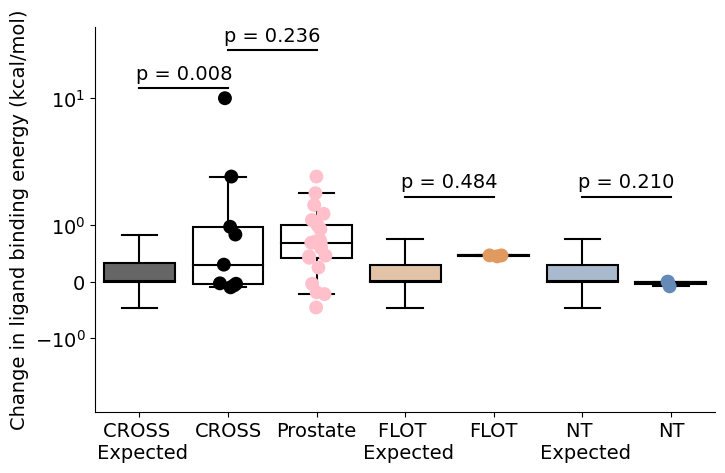

In [28]:
fig, ax = plt.subplots()

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

g = sns.boxplot(data = combined, x = "label", y = "score"
                , palette = ["k", "w", "w", "#E0995E", "w", "#668AB8", "w", "w"], showfliers = False)
for patch in ax.patches:
    r, g1, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g1, b, 0.6))

g2 = sns.stripplot(data = combined2, x = "label", y = "score", palette=["w", "k", "pink", "w","#E0995E", "w","#668AB8"], size = 10)

x1, x2 = 0, 1  
y, h, col = 12.5, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+1.5, "p = 0.008", ha='center', va='bottom', color=col, size = 14)


x1, x2 = 3, 4  
y, h, col = 1.5, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+.1, "p = 0.484", ha='center', va='bottom', color=col, size = 14)

x1, x2 = 5, 6  
y, h, col = 1.5, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+.1, "p = 0.210", ha='center', va='bottom', color=col, size = 14)

x1, x2 = 1, 2  
y, h, col = 30, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+3, "p = 0.236", ha='center', va='bottom', color=col, size = 14)

g.set_xlabel("")
g.set_xticklabels(["CROSS \n Expected", "CROSS", "Prostate", "FLOT \n Expected", "FLOT", "NT \n Expected", "NT"], size = 14)

g.set_ylabel("Change in ligand binding energy (kcal/mol)", size = 14)
g.set_yticklabels(g.get_yticklabels(), size = 14)
ax.set_yscale("symlog")
ax.set_ylim(-3, 50)
sns.despine()

plt.savefig("SPOP_binding_energy.pdf", bbox_inches = "tight")

## Foldx DDG

In [29]:
from darwinian_shift import FoldXLookup

fold = FoldXLookup(foldx_results_directory = "../Foldx/",
                  sifts_directory = ".",
                  download_sifts=True)

SPOP = {
    "gene": "SPOP",
    "pdb_id": "3HQI",
    "pdb_chain": "A",
}

In [30]:
myriad_spop = pd.read_csv("../Foldx/3HQI/ChainA/PS_f0_scanning_output_MYRIAD.txt")

FileNotFoundError: [Errno 2] No such file or directory: '../Foldx/3HQI/ChainA/PS_f0_scanning_output_MYRIAD.txt'

In [ ]:
subset = myriad_spop[["pdb_mut", "ddg"]]

In [ ]:
subset.to_csv("../Foldx/3HQI/ChainA/PS_f0_scanning_output.txt", index = False, header=False, sep = "\t")

## CROSS

In [ ]:
s_cross = d_CROSS.run_section(SPOP, lookup=fold, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

In [ ]:
s_cross.get_pvalues()

## FLOT

In [ ]:
s_flot = d_FLOT.run_section(SPOP, lookup=fold, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

In [ ]:
s_flot.get_pvalues()

## NT

In [ ]:
s_nt = d_NT.run_section(SPOP, lookup=fold, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

In [ ]:
s_nt.get_pvalues()

## Plotting

In [ ]:
data_cross = plot_boxplot2(s_cross)
data_flot = plot_boxplot2(s_flot)
data_nt= plot_boxplot2(s_nt)

basedistcross = data_cross[0]
crossdist = data_cross[1]
basedistflot = data_flot[0]
flotdist = data_flot[1]
basedistnt = data_flot[0]
ntdist = data_nt[1]

basedistcross = pd.DataFrame(basedistcross)
basedistcross["label"] = "base_cross"
basedistcross.columns = ["score", "label"]

basedistflot = pd.DataFrame(basedistflot)
basedistflot["label"] = "base_flot"
basedistflot.columns = ["score", "label"]

basedistnt = pd.DataFrame(basedistnt)
basedistnt["label"] = "base_nt"
basedistnt.columns = ["score", "label"]

crossdist = pd.DataFrame(crossdist)
crossdist["label"] = "cross"

flotdist = pd.DataFrame(flotdist)
flotdist["label"] = "flot"

ntdist = pd.DataFrame(ntdist)
ntdist["label"] = "nt"

testdist_cross = pd.DataFrame([-15])
testdist_cross["label"] = "base_cross"
testdist_cross.columns = ["score", "label"]

testdist_flot = pd.DataFrame([-15])
testdist_flot["label"] = "base_flot"
testdist_flot.columns = ["score", "label"]

testdist_nt = pd.DataFrame([-15])
testdist_nt["label"] = "base_nt"
testdist_nt.columns = ["score", "label"]

combined = pd.concat([basedistcross, crossdist, basedistflot, flotdist,basedistnt, ntdist], axis =0)
combined2 = pd.concat([testdist_cross, crossdist,testdist_flot, flotdist,testdist_nt, ntdist], axis =0)

In [ ]:
plt.rcParams['figure.figsize'] = [8, 6]

In [ ]:
 fig, ax = plt.subplots()

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}


g = sns.boxplot(data = combined, x = "label", y = "score"
                , palette = ["k", "w", "#E0995E", "w", "#668AB8", "w"], showfliers = False)
for patch in ax.patches:
    r, g1, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g1, b, 0.6))

g2 = sns.stripplot(data = combined2, x = "label", y = "score", palette=["w", "k","w", "#E0995E","w", "#668AB8"], size = 10)

x1, x2 = 0, 1  
y, h, col = 32, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.2, "p = 0.049", ha='center', va='bottom', color=col, size = 14)


x1, x2 = 2, 3  
y, h, col = 32, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.2, "p = 0.0002", ha='center', va='bottom', color=col, size = 14)

x1, x2 = 4, 5  
y, h, col = 32, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.2, "p = 0.182", ha='center', va='bottom', color=col, size = 14)

g.set_xlabel("")
g.set_xticklabels(["CROSS \nExpected", "CROSS", "FLOT \nExpected", "FLOT", "NT \nExpected", "NT"], size = 12)

g.set_ylabel(r"Mutational $\Delta$$\Delta$G (kcal/mol)", size = 14)
g.set_yticklabels(g.get_yticklabels(), size = 14)

#g.set_yscale("symlog")

ax.set_ylim(-5, 35)
sns.despine()


g.set_yticklabels([0,0,5,10,15,20,25,30, 35], size = 14)

plt.savefig("SPOP_foldxDDG.pdf")
plt.show()